# Notebook written to handle with the data, and get the first results. 
This notebook mainly focuses on Holt-Winter methods. We can notice, for the following, that neither 'mul' nor 'multiplicative' work for the Holt-Winter method. However, this multiplicative ways to do are more suited to our problem, given that we have high variations in our data. 

In [108]:
import os, sys
import time

import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm

In [2]:
train_filename = "Train_SU63ISt.csv"
path_to_file = f"DATA/{train_filename}"
data = pd.read_csv(path_to_file, usecols=[1, 2], engine="python")

In [3]:
data['Date'] = pd.to_datetime(data['Datetime'])
data.index = data.Date
data = data.drop(['Datetime','Date'], axis=1)

In [4]:
# Impose frequency of data to ease the next treatments
data = data.asfreq('H')
# Sort the data by dates 
data = data.sort_index()

In [5]:
data.head(10)

,Count
Date,
2012-08-25 00:00:00,8.0
2012-08-25 01:00:00,2.0
2012-08-25 02:00:00,6.0
2012-08-25 03:00:00,2.0
2012-08-25 04:00:00,2.0
2012-08-25 05:00:00,2.0
2012-08-25 06:00:00,2.0
2012-08-25 07:00:00,2.0
2012-08-25 08:00:00,6.0


# Handle 'Nan' values which would polute the predictions made by our models

In [60]:
### Missing values (NaN) in train data 
# Counting cells with missing values 
train_missing_cells = sum(data.isnull().values.ravel())
#Counting rows that have missing values somewhere 
train_missing_lines = sum(data.apply(lambda x: sum(x.isnull().values), axis = 1)>0)
print('In train data, there are %s NaN cells, among %s lines' %(train_missing_cells, train_missing_lines))

count = 0
for i in range(data.shape[0]):
    if (np.isnan(data.Count.iloc[i])):
        count += 1
        data.Count.iloc[i] = data.Count.iloc[i-1]
print(count)

# Counting cells with missing values 
train_missing_cells = sum(data.isnull().values.ravel())
#Counting rows that have missing values somewhere 
train_missing_lines = sum(data.apply(lambda x: sum(x.isnull().values), axis = 1)>0)
print('In train data, there are %s NaN cells, among %s lines' %(train_missing_cells, train_missing_lines))

In train data, there are 1416 NaN cells, among 1416 lines
1416
In train data, there are 0 NaN cells, among 0 lines


# Split training and testing data 

In [61]:
train = data[:int(data.shape[0]*0.4)]
test = data[int(data.shape[0]*0.4):int(data.shape[0]*0.5)]

print('Train starts at %s and ends at %s' %(train.index.min(),train.index.max()))
print('Test starts at %s and ends at %s' %(test.index.min(),test.index.max()))

Train starts at 2012-08-25 00:00:00 and ends at 2013-06-25 18:00:00
Test starts at 2013-06-25 19:00:00 and ends at 2013-09-09 23:00:00


In [62]:
train.index.freq

<Hour>

In [63]:
train.head()

,Count
Date,
2012-08-25 00:00:00,8.0
2012-08-25 01:00:00,2.0
2012-08-25 02:00:00,6.0
2012-08-25 03:00:00,2.0
2012-08-25 04:00:00,2.0


In [64]:
train.tail()

,Count
Date,
2013-06-25 14:00:00,98.0
2013-06-25 15:00:00,98.0
2013-06-25 16:00:00,128.0
2013-06-25 17:00:00,112.0
2013-06-25 18:00:00,124.0


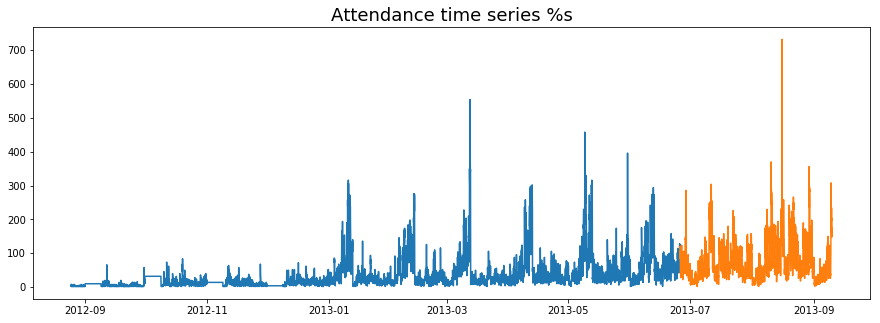

In [109]:
### Observe the data and get an idea of what we are dealing with
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(train.index, train.Count)
ax.plot(test.index, test.Count)
title= 'Attendance time series %s'
ax.set_title(title,fontsize=18)
#fig.savefig('sales_time_series.png', bbox_inches='tight')
plt.show()

# HOLT-WINTER MODEL : a first step towards prediction 

In [66]:
v = pd.DataFrame(data=np.array([4,2,3,np.NaN,8]))
mean_squared_error(v.values[v.notna().values], np.array([2,2,2,2]))

10.25

In [67]:
train.shape

(7315, 1)

In [68]:
# Quickly check that there is no missing date : check that our dataset has a coherent number of lines
pd.date_range(start=str(train.index.min()), end=str(train.index.max()), freq='60min')

DatetimeIndex(['2012-08-25 00:00:00', '2012-08-25 01:00:00',
               '2012-08-25 02:00:00', '2012-08-25 03:00:00',
               '2012-08-25 04:00:00', '2012-08-25 05:00:00',
               '2012-08-25 06:00:00', '2012-08-25 07:00:00',
               '2012-08-25 08:00:00', '2012-08-25 09:00:00',
               ...
               '2013-06-25 09:00:00', '2013-06-25 10:00:00',
               '2013-06-25 11:00:00', '2013-06-25 12:00:00',
               '2013-06-25 13:00:00', '2013-06-25 14:00:00',
               '2013-06-25 15:00:00', '2013-06-25 16:00:00',
               '2013-06-25 17:00:00', '2013-06-25 18:00:00'],
              dtype='datetime64[ns]', length=7315, freq='60T')

In [70]:
### Test the seasonality which seems to be the most appropriated : this run is very long 

y_hat_avg = test.copy()
rmse_scores = []
P = 30
periods = np.arange(2,P)

testing = false

if testing:
    for p in periods:
        fitted = ExponentialSmoothing(train['Count'].values, seasonal_periods=p ,trend='add', seasonal='add').fit()
        forcasted = fitted.forecast(len(test))
        forcasted = forcasted.reshape(forcasted.shape[0],1)
        filterNa = pd.DataFrame(data=forcasted).notna().values
        if (len(test.Count.values[filterNa[:,0]]) > 2):
            rms = sqrt(mean_squared_error(test.Count.values[filterNa[:,0]], forcasted[filterNa[:,0]]))
        else:
            rms = 1e5
        rmse_scores.append(rms)

        if (p < (P-1)):
            sys.stdout.write('Seasonal period : %s ; RMS : %s\r' %(p,rms))
            sys.stdout.flush()   
        else:
            print('Seasonal period : %s ; RMS : %s\r' %(p,rms))

    print('Min for seasonal period : %s' %(np.argmin(rmse_scores)+2))

Seasonal period : 29 ; RMS : 91.227657375445051
Min for seasonal period : 24


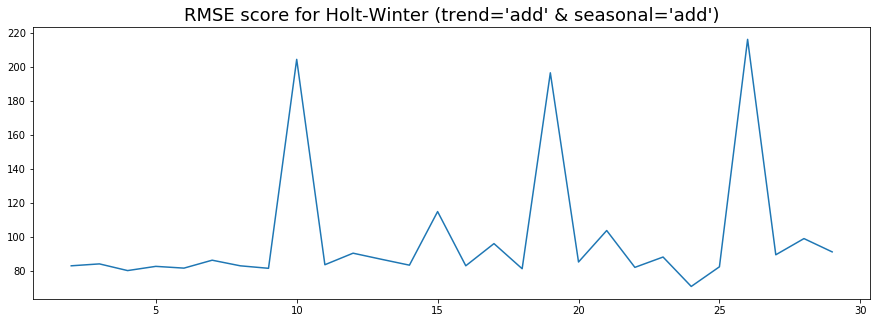

In [72]:
if testing:
    #Plotting data
    fig,ax = plt.subplots(figsize=(15,5))
    ax.plot(periods, rmse_scores)

    title= "RMSE score for Holt-Winter (trend='add' & seasonal='add')"
    ax.set_title(title,fontsize=18)
    fig.savefig('rmse_holt_winter.png', bbox_inches='tight')
    plt.show()

The minimum is reach for seasonal = 24 : there are 24 measurements per day, this is coherent. 

In [104]:
# Build and predict with a model which has a seasonality 24
fitted = ExponentialSmoothing(train['Count'].values, seasonal_periods=24 ,trend='add', seasonal='add').fit()
forcasted = fitted.forecast(len(test))
forcasted = forcasted.reshape(forcasted.shape[0],1)
filterNa = pd.DataFrame(data=forcasted).notna().values
if (len(test.Count.values[filterNa[:,0]]) > 2):
    print("RMSE can be calculated")
    rms_holt = sqrt(mean_squared_error(test.Count.values[filterNa[:,0]], forcasted[filterNa[:,0]]))
else:
    print("RMSE can't be calculated")

RMSE can be calculated


In [105]:
print(rms_holt)

70.87456174122413


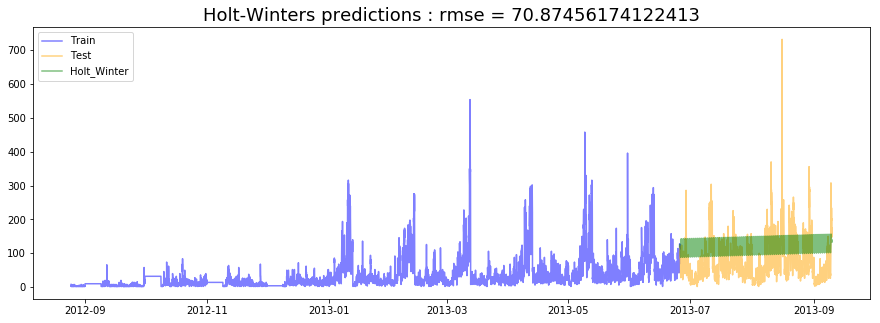

In [106]:
# Plotting 
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(train['Count'], label='Train', c='b', alpha=0.5)
ax.plot(test['Count'], label='Test', c='orange', alpha=0.5)
ax.plot(test.index.values,forcasted, label='Holt_Winter', c='green', alpha=0.5)
plt.legend(loc='best')
title = "Holt-Winters predictions : rmse = %s" %(rms_holt)
ax.set_title(title, fontsize=18)
plt.show()
fig.savefig('holt_winter.png', bbox_inches='tight')

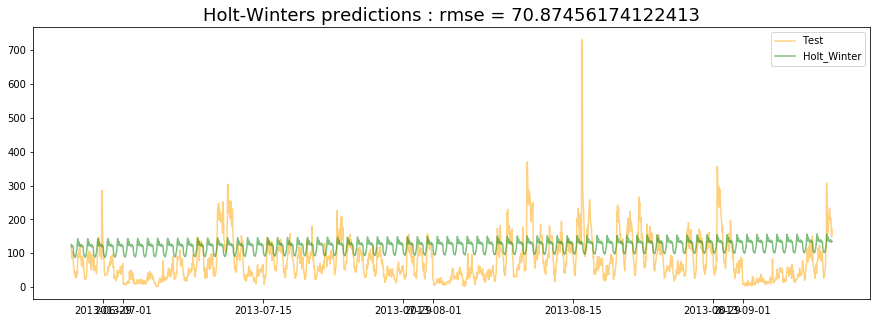

In [107]:
# Plotting test only 
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(test['Count'], label='Test', c='orange', alpha=0.5)
ax.plot(test.index.values,forcasted, label='Holt_Winter', c='green', alpha=0.5)
plt.legend(loc='best')
title = "Holt-Winters predictions : rmse = %s" %(rms_holt)
ax.set_title(title, fontsize=18)
plt.show()
fig.savefig('holt_winter_test.png', bbox_inches='tight')

# ARMA-ARIMA : not handled yet

In [23]:
# ARMA-ARIMA 
prediction_start_date = str(test.index.min())
prediction_end_date = str(test.index.max())
num_records = train.shape[0]

In [24]:
print(train.index.freq)
print(train.index.inferred_freq)

<Hour>
H


In [ ]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(1,1,1,12)).fit(cov_type='robust', method='cg', trend='ct')

In [38]:
y_hat_avg['SARIMA'] = fit1.predict(start=prediction_start_date, end=prediction_end_date, dynamic=True)

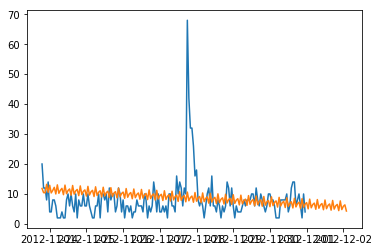

In [36]:
plt.plot(test.Count[:200])
plt.plot(y_hat_avg['SARIMA'][:200])

In [34]:
rms_arima = sqrt(mean_squared_error(test.Count[:20], y_hat_avg['SARIMA'][:20]))
print(rms_arima)

6.43783999798408
